In [1]:
from apps.onedimensional.shallowwater import shallow_water as sw
from apps.onedimensional.shallowwater.manufacturedsolutionexample import manufactured_solution_example as sw_mse
from pydogpack import main
from pydogpack.tests.utils import utils
from pydogpack.timestepping import explicit_runge_kutta
from pydogpack.utils import dg_utils
from pydogpack.utils import math_utils
from pydogpack.utils import x_functions
from pydogpack.utils import xt_functions
from pydogpack.visualize import plot

import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10]

from IPython.display import HTML

# Manufactured Solution

In [14]:
gravity_constant = 1.0
include_v = True

# q1 = xt_functions.AdvectingSine(0.05, 1.0, 1.0, 0.0, 1.0)
# q2 = xt_functions.AdvectingSine(0.05, 1.0, 0.0, 0.0, 1.0)
# q3 = xt_functions.AdvectingSine(0.05, 1.0, 0.0, 0.0, 1.0)

q1 = xt_functions.AdvectingPeriodicGaussian(0.1, 8.0, 1.0, 0.4, 1.0, 1.0)
q2 = xt_functions.AdvectingPeriodicGaussian(0.1, 8.0, 1.0, 0.4, 0.0, 1.0)
q3 = xt_functions.AdvectingPeriodicGaussian(0.1, 8.0, 1.0, 0.4, 0.0, 1.0)
list_ = [q1, q2]
if include_v:
    list_.append(q3)
exact_solution = xt_functions.ComposedVector(list_)

max_wavespeed = 0.1 + np.sqrt(gravity_constant * 1.1)

problem = sw_mse.ManufacturedSolutionExample(
    exact_solution,
    max_wavespeed,
    gravity_constant,
    include_v,
)

time_final = 0.2
problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

space_time_order = 3
problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = True
problem.parameters["time_stepping"]["num_frames"] = 5
problem.parameters["time_stepping"]["order"] = space_time_order

num_elems = 80
x_left = 0.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right
problem.parameters["mesh"]["num_elems"] = num_elems

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5
problem.parameters["basis"]["num_basis_cpts"] = space_time_order

problem.parameters["boundary_condition"]["boundary_condition_class"] = "periodic"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "local_lax_friedrichs"

cfl = explicit_runge_kutta.get_cfl(space_time_order)
#cfl = 0.5
delta_x = (x_right - x_left) / num_elems
delta_t = float(dg_utils.get_delta_t(cfl, problem.max_wavespeed, delta_x))
problem.parameters["delta_t"] = delta_t

problem._setup_objects()

In [15]:
final_solution = main.run(problem)

20.0%
Will finish in 0:00:28.716380 at 10:21:21.631117
40.0%
Will finish in 0:00:21.459016 at 10:21:21.500669
60.0%
Will finish in 0:00:14.200079 at 10:21:21.235839
80.0%
Will finish in 0:00:07.048952 at 10:21:20.980404
100.0%
Will finish in 0:00:00 at 10:21:20.849571


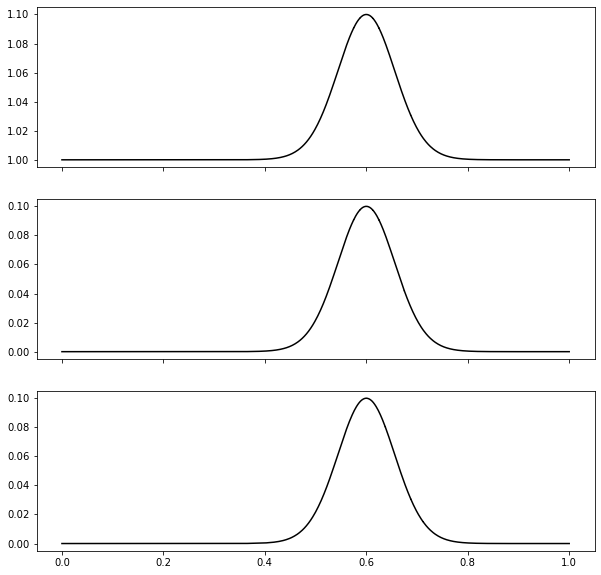

In [16]:
exact_final_solution = x_functions.FrozenT(problem.exact_solution, time_final)
exact_final_height = x_functions.FrozenT(list_[0], time_final)
exact_final_momentum = x_functions.FrozenT(list_[1], time_final)
fig = plot.create_plot_dg_1d(final_solution)
#lines = plot.plot_function(fig.axes, exact_final_solution, x_left, x_right, style='b')

#ani, fig = plot.create_animation_output_dir(problem.output_dir, problem.exact_solution)
#HTML(ani.to_html5_video())

In [49]:
error = math_utils.compute_error(final_solution, exact_final_solution)
error

0.0002046227259031517

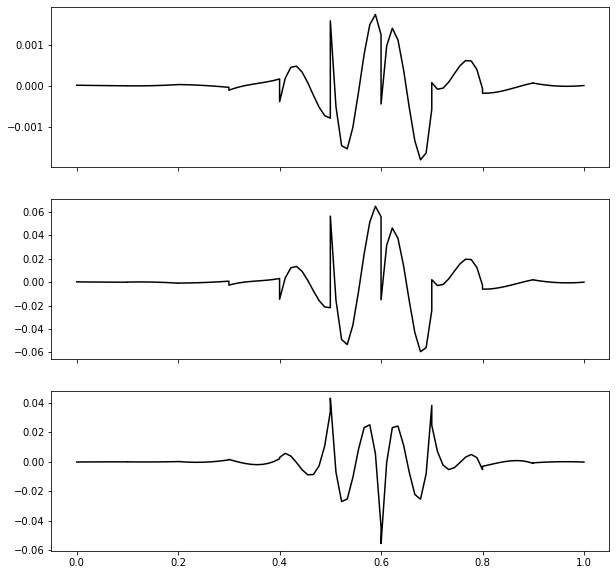

In [5]:
dg_error = math_utils.compute_dg_error(final_solution, exact_final_solution)
p = dg_error.create_plot()

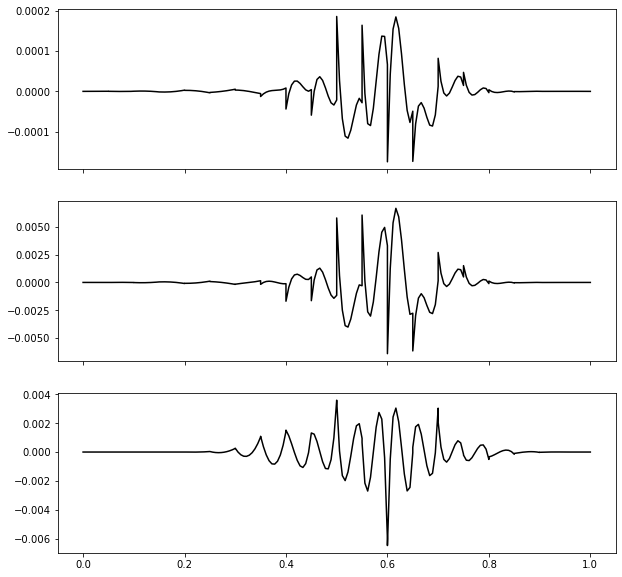

In [9]:
dg_error = math_utils.compute_dg_error(final_solution, exact_final_solution)
p = dg_error.create_plot()

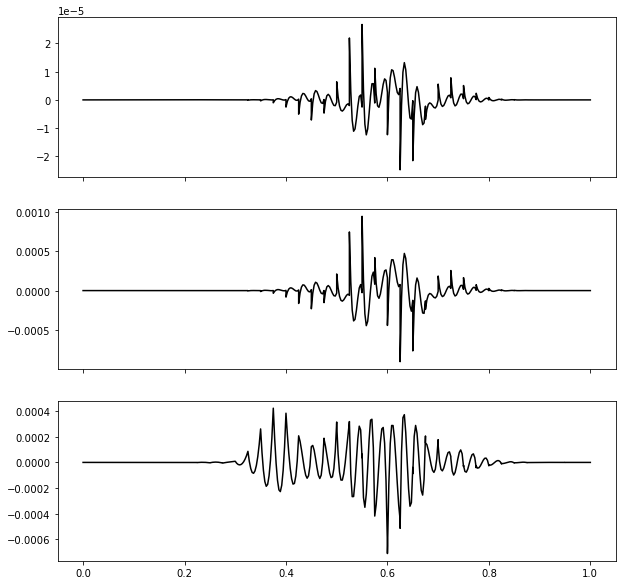

In [13]:
dg_error = math_utils.compute_dg_error(final_solution, exact_final_solution)
p = dg_error.create_plot()

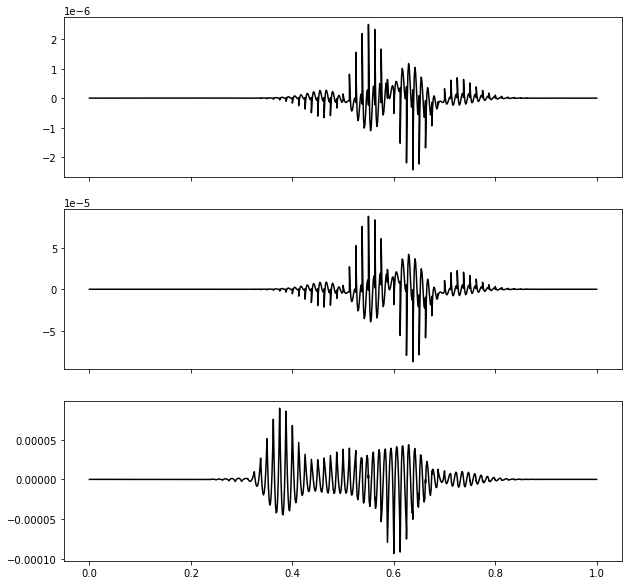

In [17]:
dg_error = math_utils.compute_dg_error(final_solution, exact_final_solution)
p = dg_error.create_plot()

## Convergence Test

In [31]:
gravity_constant = 1.0
include_v = True

q1 = xt_functions.AdvectingSine(0.1, 1.0, 1.0, 0.0, 1.0)
q2 = xt_functions.AdvectingSine(0.1, 1.0, 0.0, 0.1, 1.0)
q3 = xt_functions.AdvectingSine(0.1, 1.0, 0.0, 0.2, 1.0)

# q1 = xt_functions.AdvectingPeriodicGaussian(0.1, 5.0, 1.0, 0.4, 1.0, 1.0)
# q2 = xt_functions.AdvectingPeriodicGaussian(0.1, 5.0, 1.0, 0.4, 0.0, 1.0)
# q3 = xt_functions.AdvectingPeriodicGaussian(0.1, 5.0, 1.0, 0.4, 0.0, 1.0)
list_ = [q1, q2]
if include_v:
    list_.append(q3)
exact_solution = xt_functions.ComposedVector(list_)

max_wavespeed = 0.1 + np.sqrt(gravity_constant * 1.1)

problem = sw_mse.ManufacturedSolutionExample(
    exact_solution,
    max_wavespeed,
    gravity_constant,
    include_v,
)

time_final = 0.2
exact_final_solution = x_functions.FrozenT(problem.exact_solution, time_final)
problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False
problem.parameters["time_stepping"]["num_frames"] = 10

x_left = 0.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5

problem.parameters["boundary_condition"]["boundary_condition_class"] = "periodic"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "local_lax_friedrichs"

In [33]:
for num_basis_cpts in range(3, 4):
    problem.parameters["basis"]["num_basis_cpts"] = num_basis_cpts
    problem.parameters["time_stepping"]["order"] = num_basis_cpts
    
    cfl = explicit_runge_kutta.get_cfl(num_basis_cpts)
    error_list = []
    h_list = []
    final_solution_list = []
    for num_elems in [10, 20, 40, 80, 160, 320]:
        delta_x = (x_right - x_left) / num_elems
        delta_t = float(dg_utils.get_delta_t(cfl, problem.max_wavespeed, delta_x))
        problem.parameters["delta_t"] = delta_t
        problem.parameters["mesh"]["num_elems"] = num_elems
        
        problem._setup_objects()
        final_solution = main.run(problem)
        final_solution_list.append(final_solution)
        
        error = math_utils.compute_error_by_equation(final_solution, exact_final_solution)
        error_list.append(error)
        h_list.append(delta_x)
    order_list = utils.convergence_order_by_equation(error_list, h_list)
    print("Orders")
    for order in order_list:
        print(order)
    print("Errors")
    for error in error_list:
        print(error)
#     if error_list[-1] >= math_utils.MACHINE_ERROR:
#         assert np.round(order) >= num_basis_cpts

Orders
[2.96430599 2.99928325 2.00157385]
[2.9849929  3.00309694 2.10542012]
[2.99381134 3.00343117 2.23220615]
[2.99726977 3.00208477 2.35224925]
[2.99871835 3.00106375 2.43846944]
Errors
[8.87775851e-05 1.29243765e-03 2.21865581e-03]
[1.13751808e-05 1.61634989e-04 5.54059192e-04]
[1.43676556e-06 2.01610488e-05 1.28754245e-04]
[1.80367752e-07 2.51414458e-06 2.74031538e-05]
[2.25886765e-08 3.13814267e-07 5.36664621e-06]
[2.82609407e-09 3.91978706e-08 9.90034940e-07]


In [34]:
dg_error_list = [math_utils.compute_dg_error(final_solution, exact_final_solution) for final_solution in final_solution_list]

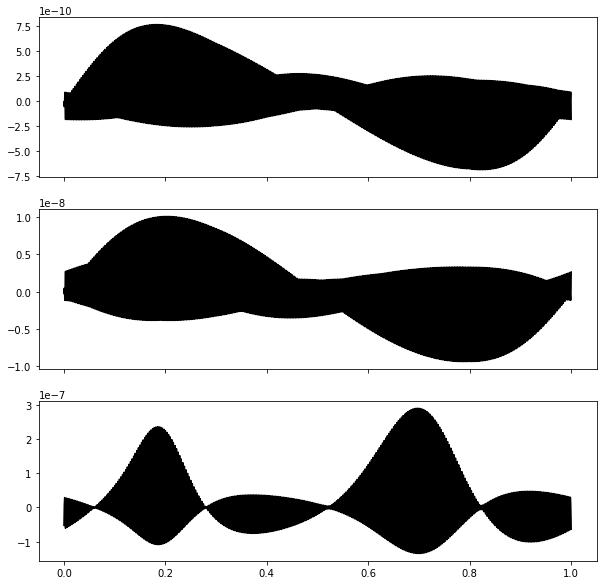

In [42]:
p = dg_error_list[5].create_plot()

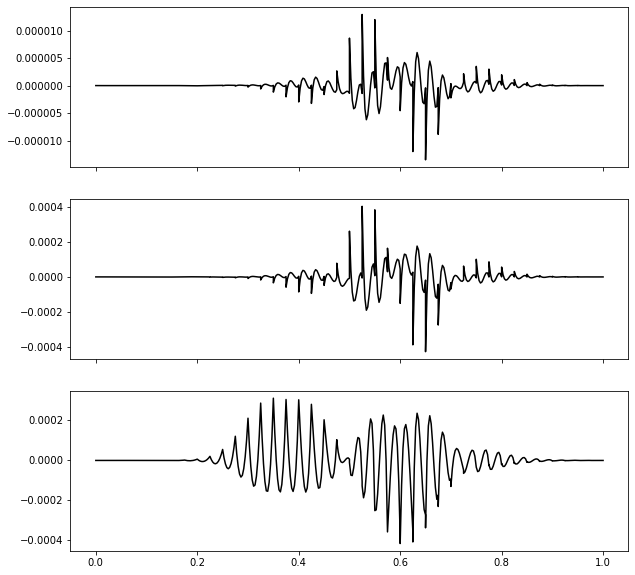

In [24]:
p = dg_error_list[1].create_plot()

In [23]:
eqn_error = math_utils.compute_error_by_equation(final_solution_list[0], exact_final_solution)

In [24]:
eqn_error

array([1.21406551e-06, 3.88941273e-05, 7.76599842e-05])